In [7]:
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
pd.set_option('future.no_silent_downcasting', True)

In [8]:
def load_data_symptom(
                        data_path = "data/symptoms_dataset.csv",
                        class_dict = {
                                    'Gastrointestinal Issues' : 0,
                                    'Arthritis' : 1, 'Food Poisoning' : 2,
                                    'Respiratory Infection' : 3,
                                    'Chronic Fatigue Syndrome' : 4,
                                    'Heart Disease' : 5, 'Vertigo' : 6,
                                    'Infection' : 7,
                                    'Migraine' : 8,
                                    'Asthma' : 9
                                    }
                        ):
    df = pd.read_csv(data_path)
    df = df.replace("Yes", 1)
    df = df.replace("No", 0)
    df["Disease"] = df["Disease"].map(class_dict)
    X = df.drop(columns = ["Disease"]).values
    Y = df["Disease"].values

    X = np.repeat(X, 10, axis=0)
    Y = np.repeat(Y, 10, axis=0)
    X, Y = shuffle(X, Y)
    return X, Y

In [9]:
X, Y = load_data_symptom()
print(f"X Shape: {X.shape}")
print(f"Y Shape: {Y.shape}")

X Shape: (5000, 11)
Y Shape: (5000,)


In [10]:
cls_01 = RandomForestClassifier(
                            n_estimators = 200, 
                            max_depth = 10
                            )

cls_02 = XGBClassifier(
                    n_estimators = 200,
                    max_depth = 10
                    )

cls = VotingClassifier(
                    estimators = [
                        ('cls_01', cls_01),
                        ('cls_02', cls_02)
                    ]
                    )

In [11]:
cls.fit(X, Y)

VotingClassifier(estimators=[('cls_01',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200)),
                             ('cls_02',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [27]:
with open("artifacts/symptoms_model.pkl", "wb") as f:
    pickle.dump(cls, f)

### evaluation

In [13]:
class_dict = {
            'Gastrointestinal Issues' : 0,
            'Arthritis' : 1, 'Food Poisoning' : 2,
            'Respiratory Infection' : 3,
            'Chronic Fatigue Syndrome' : 4,
            'Heart Disease' : 5, 'Vertigo' : 6,
            'Infection' : 7,
            'Migraine' : 8,
            'Asthma' : 9
            }

P = cls.predict(X)
cls_report = classification_report(Y, P, target_names = list(class_dict.keys()))
print(cls_report)

                          precision    recall  f1-score   support

 Gastrointestinal Issues       0.93      0.93      0.93       450
               Arthritis       0.88      0.98      0.93       530
          Food Poisoning       0.82      0.97      0.89       380
   Respiratory Infection       0.92      0.97      0.94       620
Chronic Fatigue Syndrome       0.85      0.88      0.87       520
           Heart Disease       0.87      0.89      0.88       540
                 Vertigo       0.87      0.84      0.85       550
               Infection       0.88      0.83      0.85       520
                Migraine       0.97      0.75      0.85       440
                  Asthma       0.95      0.87      0.91       450

                accuracy                           0.89      5000
               macro avg       0.90      0.89      0.89      5000
            weighted avg       0.89      0.89      0.89      5000



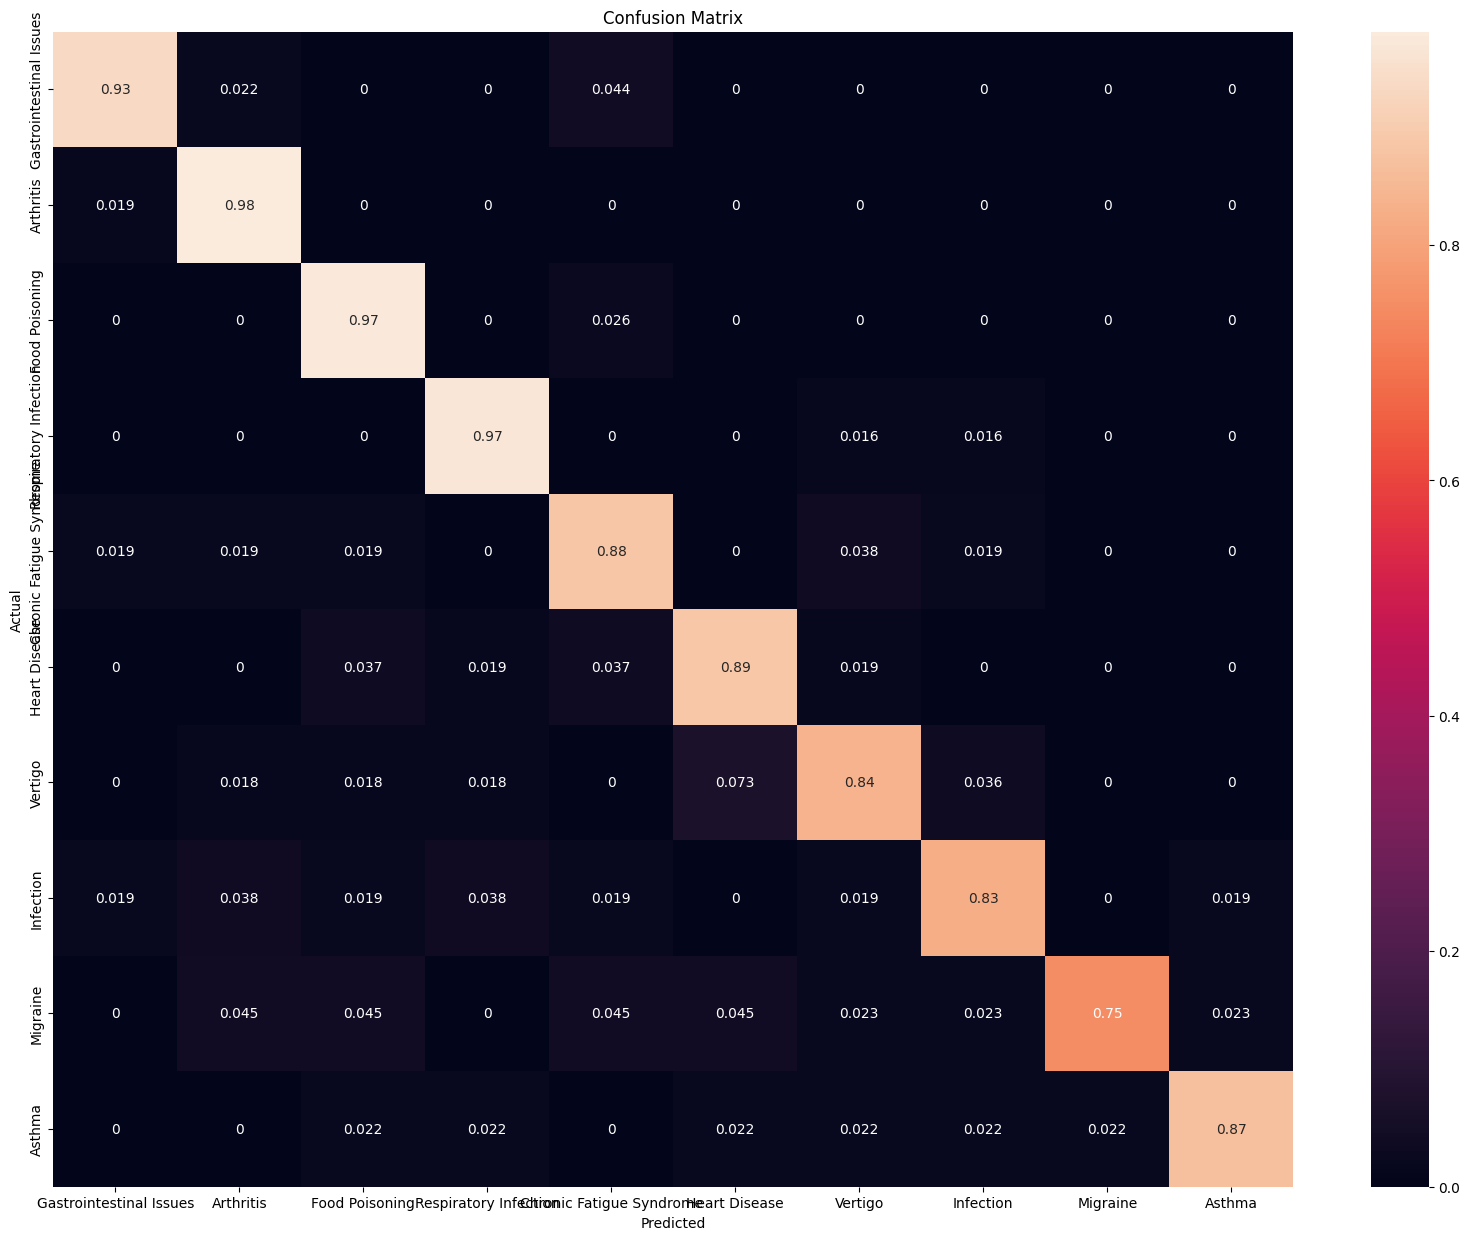

In [24]:
cm = confusion_matrix(Y, P)
cm = cm / cm.sum(axis = 1).reshape(-1, 1)
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot = True)
plt.xticks(ticks = np.arange(10) + 0.5, labels = list(class_dict.keys()))
plt.yticks(ticks = np.arange(10) + 0.5, labels = list(class_dict.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### inference

In [29]:
with open("artifacts/symptoms_model.pkl", "rb") as f:
    model_symptom = pickle.load(f)

In [32]:
sample_json = {
            "Past Disease":"No",
            "Chest Pain":1,
            "Fever":1,
            "Shortness of Breath":0,
            "Fatigue":0,
            "Joint Pain":0,
            "Headache":1,
            "Cough":0,
            "Abdominal Pain":1,
            "Dizziness":1,
            "Nausea":0
            }

In [33]:
def predict_symptom(
                    sample_json,
                    class_dict = {
                                    'Gastrointestinal Issues' : 0,
                                    'Arthritis' : 1, 'Food Poisoning' : 2,
                                    'Respiratory Infection' : 3,
                                    'Chronic Fatigue Syndrome' : 4,
                                    'Heart Disease' : 5, 'Vertigo' : 6,
                                    'Infection' : 7,
                                    'Migraine' : 8,
                                    'Asthma' : 9
                                    }
                    ):
    df = pd.DataFrame(sample_json, index = [0])
    df = df.replace("Yes", 1)
    df = df.replace("No", 0)
    X = df.values
    Y = model_symptom.predict(X)
    return list(class_dict.keys())[Y[0]]

In [34]:
predict_symptom(sample_json)

'Gastrointestinal Issues'